# Market Model

An artificial cryptocurrency market, experimenting the effects of social networks on price dynamics

In [167]:
from model import MarketModel
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import networkx as nx
from ipywidgets import widgets
from IPython.display import display
from cycler import cycler

### Parameters
#### Model-Wide
- $\text{Agents}$ = Number of agents (30% are Random Traders)
- $\text{Price}$ = Initial Starting Price
- $\text{Timesteps}$ = Total Time-Steps

#### Agent-Wide
- $\alpha$ = Sensitivity of price movement
- $\beta$ = Deviation of expected price
- $\gamma$ = Upper bound of Time Horizon (Uniformly Distributed)

#### Decision Making
- $\rho$ = Logit Temperature Parameter
##### *Network* (a list [type, n, p])
- $\text{Network}$ = Network Type (regular, random, smallworld, barabasi & none)
- $n$ = 


In [2]:
agents = 100
non_random = 0.7
timesteps = 200
price= 50

alpha = 0.0005
beta = 0.001
gamma = 20

rho = 10
#network = ["smallworld", 4, 0.9]
#network = ["caveman", 5, 7]
#network = ["regular", 10, 0.3]
network = ["barabasi", 2,0.9]
convergence = False

In [3]:
model = MarketModel(steps=timesteps, agents=agents, non_random=non_random, 
                    price=price, alpha=alpha,
                    beta=beta, gamma=gamma, rho=rho, 
                    network=network, convergence=convergence)

model.run()

df_model = model.data.get_model_vars_dataframe()
df_agent = model.data.get_agent_vars_dataframe()

# Market Data

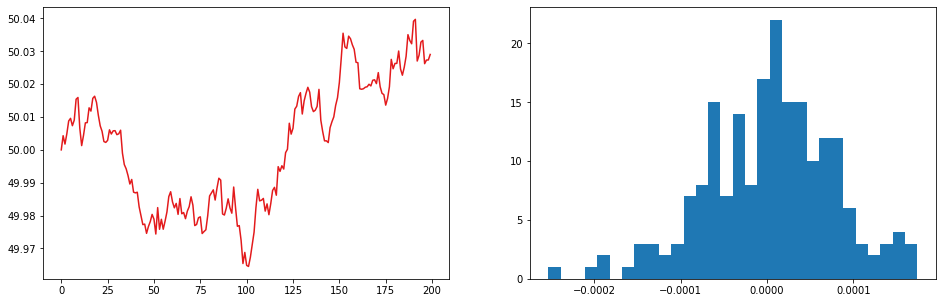

In [4]:
#plt.style.use(['science','ieee', 'retro'])
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Paired').colors)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
price = df_model["Price"]
pct_change = np.log(1+df_model["Price"].pct_change().dropna())
mu, std = norm.fit(pct_change) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(price, color=cycle[5])
ax[1].hist(pct_change, bins = 30, color = cycle[1])
plt.show()

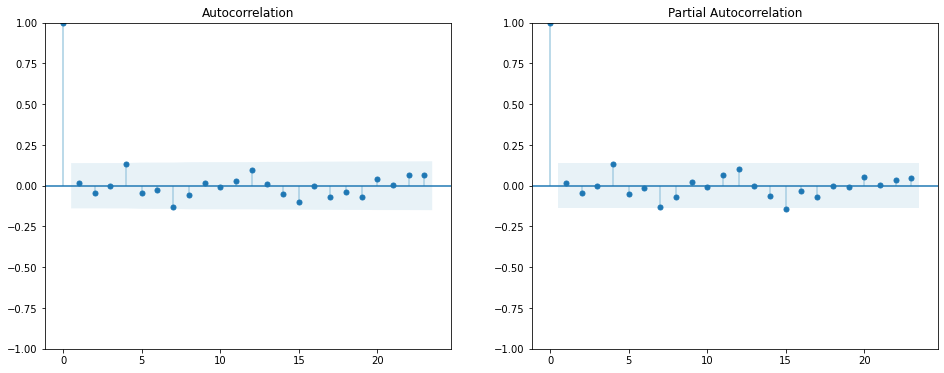

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
plot_acf(pct_change, ax=ax[0], color=cycle[1])
plot_pacf(pct_change, ax=ax[1], method = "ywm", color=cycle[1])
plt.show()

## Herding

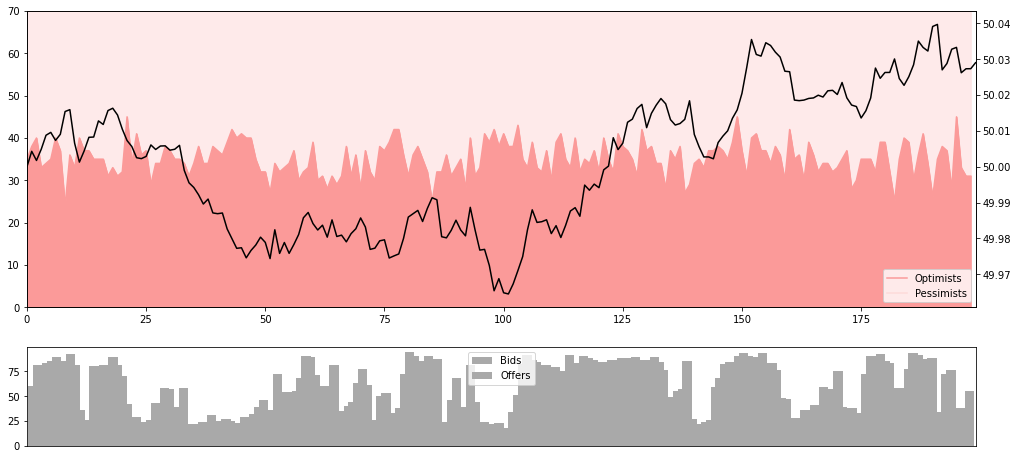

In [6]:
herding_df = pd.DataFrame()
for i in range(1,timesteps):
    type_df = df_agent.xs(i)['Trading Type'].value_counts(sort=False)
    herding_df = herding_df.append(type_df, ignore_index=True)
    
x = herding_df.index.tolist()
fig, ax = plt.subplots(2,1,figsize=(17,8),gridspec_kw={'height_ratios': [3, 1]})
labels = ['Optimists', 'Pessimists']
colors = [cycle[4], cycle[4]+(0.2,)]
herding_df[['OPTIMIST', 'PESSIMIST']].plot.area(ax=ax[0], color=colors)
price.plot(secondary_y=True, color='black', ax=ax[0])
df_model[['Bids', 'Offers']].plot.bar(ax=ax[1], stacked = True, color='darkgrey', width=2)
ax[0].legend(loc='lower right', labels=labels)
ax[0].margins(x=0)
ax[0].set_ylim(0,agents*non_random)
ax[1].set_xticks([])
plt.show()

## Network Information

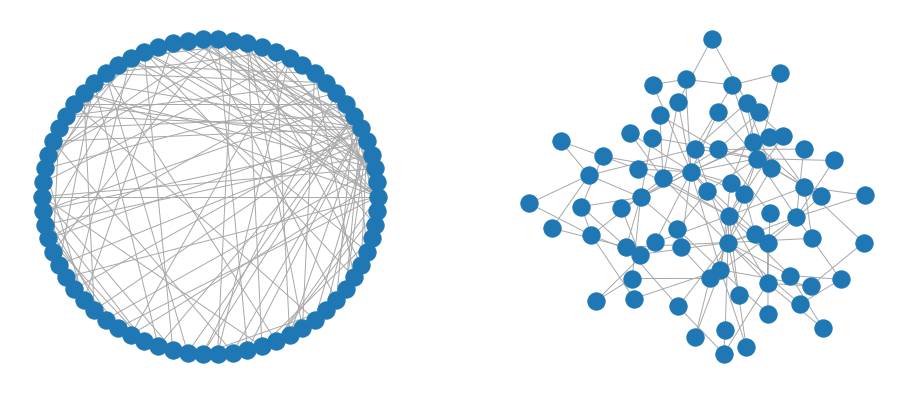

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

nx.draw(model.network, ax=ax[1], edge_color='darkgrey')
nx.draw_circular(model.network, ax=ax[0], edge_color='darkgrey')

## Tests

In [8]:
from scipy.stats import shapiro
shapiro(pct_change)

ShapiroResult(statistic=0.9897586703300476, pvalue=0.16728046536445618)

In [9]:
df_agent.xs(35, level=1)[:20].round(3)

,Trading Type,Horizon,Action,Price,Prev. Return,Expectation,Exp Return,Fitness,opt,pess,prob,rng
Step,,,,,,,,,,,,
0,PESSIMIST,12,OFFER,50.000,0.0,50.000,0.000,0.000,0.000,0.000,0.000,0.000
1,PESSIMIST,12,OFFER,50.004,0.0,50.001,0.003,0.000,0.000,0.000,0.500,0.183
2,PESSIMIST,12,OFFER,50.002,0.0,50.002,0.000,-0.004,0.004,-0.003,0.519,0.815
3,PESSIMIST,12,OFFER,50.005,0.0,50.001,0.004,0.003,0.000,0.001,0.496,0.712
4,PESSIMIST,12,OFFER,50.009,0.0,50.006,0.002,-0.003,0.000,-0.002,0.505,0.802
5,OPTIMIST,12,BID,50.010,0.0,50.010,0.001,-0.004,0.003,-0.002,0.512,0.093
6,OPTIMIST,12,BID,50.007,0.0,50.008,0.001,0.000,0.001,-0.003,0.508,0.257
7,OPTIMIST,12,BID,50.009,0.0,50.010,0.001,-0.002,-0.001,-0.000,0.499,0.153
8,PESSIMIST,12,OFFER,50.015,0.0,50.012,0.003,0.002,0.002,-0.001,0.508,0.948


In [10]:
df_agent.xs(14, level=1)[250:300].round(3)

,Trading Type,Horizon,Action,Price,Prev. Return,Expectation,Exp Return,Fitness,opt,pess,prob,rng
Step,,,,,,,,,,,,


## Agent Data

In [11]:
df_agent.xs(35, level=1)[:20].round(4) #A specific agent over time

,Trading Type,Horizon,Action,Price,Prev. Return,Expectation,Exp Return,Fitness,opt,pess,prob,rng
Step,,,,,,,,,,,,
0,PESSIMIST,12,OFFER,50.0000,0.0,49.9999,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
1,PESSIMIST,12,OFFER,50.0043,0.0,50.0009,0.0034,0.0000,0.0000,0.0000,0.5000,0.1826
2,PESSIMIST,12,OFFER,50.0018,0.0,50.0017,0.0001,-0.0043,0.0043,-0.0032,0.5189,0.8148
3,PESSIMIST,12,OFFER,50.0049,0.0,50.0007,0.0042,0.0026,0.0000,0.0015,0.4963,0.7116
4,PESSIMIST,12,OFFER,50.0088,0.0,50.0064,0.0024,-0.0031,0.0004,-0.0016,0.5048,0.8017
5,OPTIMIST,12,BID,50.0096,0.0,50.0102,0.0006,-0.0035,0.0031,-0.0019,0.5124,0.0935
6,OPTIMIST,12,BID,50.0074,0.0,50.0081,0.0007,0.0000,0.0008,-0.0026,0.5085,0.2572
7,OPTIMIST,12,BID,50.0091,0.0,50.0104,0.0013,-0.0022,-0.0010,-0.0005,0.4987,0.1527
8,PESSIMIST,12,OFFER,50.0154,0.0,50.0120,0.0034,0.0017,0.0020,-0.0013,0.5082,0.9484


In [12]:
df_agent.xs(1)[:].round(3) #All Agents by Timestep

,Trading Type,Horizon,Action,Price,Prev. Return,Expectation,Exp Return,Fitness,opt,pess,prob,rng
AgentID,,,,,,,,,,,,
0,OPTIMIST,7,BID,50.004,0.0,50.007,0.003,0.0,0.0,0.0,0.5,0.569
1,OPTIMIST,6,NOTHING,50.004,0.0,50.004,-0.000,0.0,0.0,0.0,0.5,0.899
2,OPTIMIST,19,BID,50.004,0.0,50.007,0.002,0.0,0.0,0.0,0.5,0.841
3,OPTIMIST,14,BID,50.004,0.0,50.005,0.001,0.0,0.0,0.0,0.5,0.994
4,OPTIMIST,16,BID,50.004,0.0,50.007,0.002,0.0,0.0,0.0,0.5,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...
95,RANDOM,10,NOTHING,50.004,0.0,50.003,0.001,0.0,0.0,0.0,0.0,0.000
96,RANDOM,18,OFFER,50.004,0.0,50.000,0.005,0.0,0.0,0.0,0.0,0.000
97,RANDOM,5,BID,50.004,0.0,50.003,0.001,0.0,0.0,0.0,0.0,0.000


In [13]:
returns = []

for a in model.schedule.agents:
    returns.append(pd.Series(a.returns).mean())

a.returns

array([-4.31287739e-03,  0.00000000e+00,  3.14156905e-03, -3.89590158e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.35255703e-03,
        5.27156096e-04,  0.00000000e+00, -5.27286036e-03,  3.12492074e-03,
        0.00000000e+00, -7.93975965e-05,  0.00000000e+00,  0.00000000e+00,
        3.88255676e-03,  0.00000000e+00, -1.88629830e-03, -3.94122077e-03,
       -3.18851453e-03, -1.66642337e-03,  3.12247944e-03, -2.60668280e-04,
       -6.14353595e-04,  3.21206246e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.57916142e-04,  0.00000000e+00,
       -6.98955550e-03,  3.47421131e-03,  1.29183758e-03,  0.00000000e+00,
        2.58390918e-03, -1.38140613e-03,  3.86764798e-03,  2.13353425e-04,
        0.00000000e+00,  4.44809549e-03, -2.70476497e-03,  0.00000000e+00,
       -1.56412604e-04,  0.00000000e+00,  0.00000000e+00,  1.51809884e-03,
        0.00000000e+00, -1.45728087e-03,  0.00000000e+00,  8.04184778e-03,
        0.00000000e+00,  

In [14]:
df_agent.xs(3, level=1)

,Trading Type,Horizon,Action,Price,Prev. Return,Expectation,Exp Return,Fitness,opt,pess,prob,rng
Step,,,,,,,,,,,,
0,OPTIMIST,14,NOTHING,50.000000,0.0,49.999196,-0.000804,0.000000,0.000000,0.000000,0.000000,0.000000
1,OPTIMIST,14,BID,50.004313,0.0,50.005329,0.001016,0.000000,0.000000,0.000000,0.500000,0.994038
2,OPTIMIST,14,BID,50.001762,0.0,50.001786,0.000024,0.000000,0.002156,-0.004313,0.516168,0.093915
3,OPTIMIST,14,BID,50.004903,0.0,50.006607,0.001704,-0.001276,-0.000099,0.000000,0.499753,0.053664
4,OPTIMIST,14,BID,50.008799,0.0,50.010275,0.001476,0.003142,0.000933,0.002551,0.495955,0.215768
...,...,...,...,...,...,...,...,...,...,...,...,...
195,PESSIMIST,14,OFFER,50.033323,0.0,50.031839,0.001484,0.000000,0.001073,0.003172,0.494753,0.769902
196,OPTIMIST,14,NOTHING,50.026240,0.0,50.024604,-0.001636,-0.000512,0.001270,-0.000256,0.503815,0.136057
197,OPTIMIST,14,NOTHING,50.027353,0.0,50.027272,-0.000081,0.004153,0.002076,0.005571,0.491266,0.117696


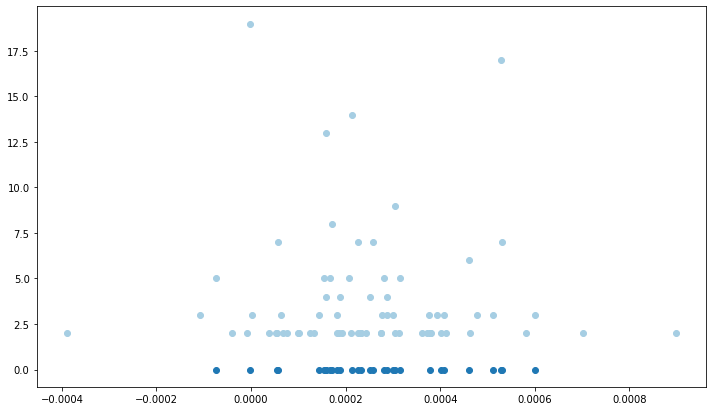

In [15]:
degree = []
rtn = []
rng_return = []
rng_zero = []

for i in range(int(non_random*agents)):
    degree.append(nx.degree(model.network)[i])
    a = model.schedule.agents[i]
    rtn.append(pd.Series(a.returns).mean())
    
for i in range(int((1-non_random)*agents)):
    a = model.schedule.agents[i]
    rng_return.append(pd.Series(a.returns).mean())
    rng_zero.append(0)
    
d = {'Degree':degree, 'Return':rtn}
profit_df = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(d['Return'], d['Degree'])
ax.scatter(rng_return, rng_zero)
plt.show()

In [150]:

R = nx.random_regular_graph(3,20)
Y = nx.watts_strogatz_graph(20,5,0.2)
B = nx.barabasi_albert_graph(20, 2)

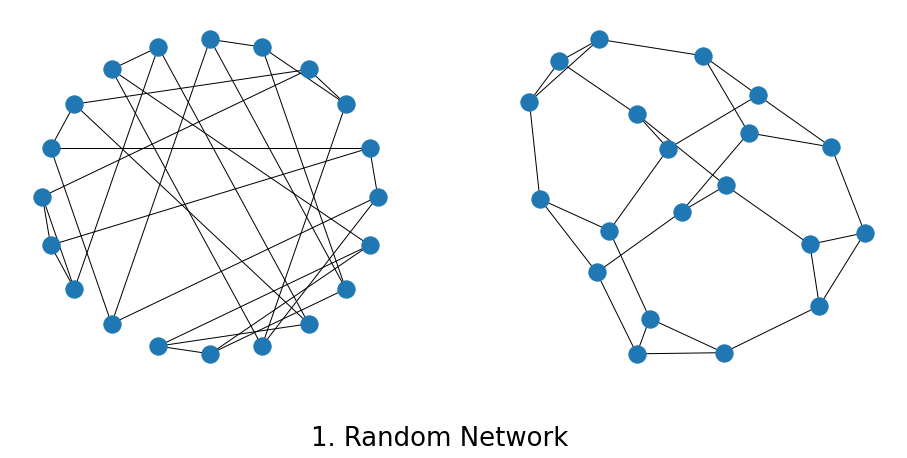

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

nx.draw(R, ax=ax[1], edge_color='black')
nx.draw_circular(R, ax=ax[0], edge_color='black')
txt="1. Random Network"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=26)

plt.savefig('../report/media/networks/random.png')

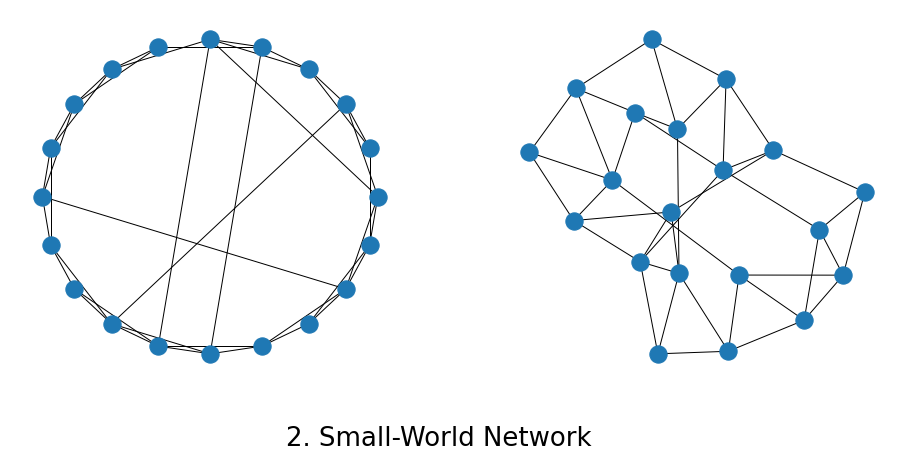

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

nx.draw(Y, ax=ax[1], edge_color='black')
nx.draw_circular(Y, ax=ax[0], edge_color='black')
txt="2. Small-World Network"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=26)
plt.savefig('../report/media/networks/smallworld.png')

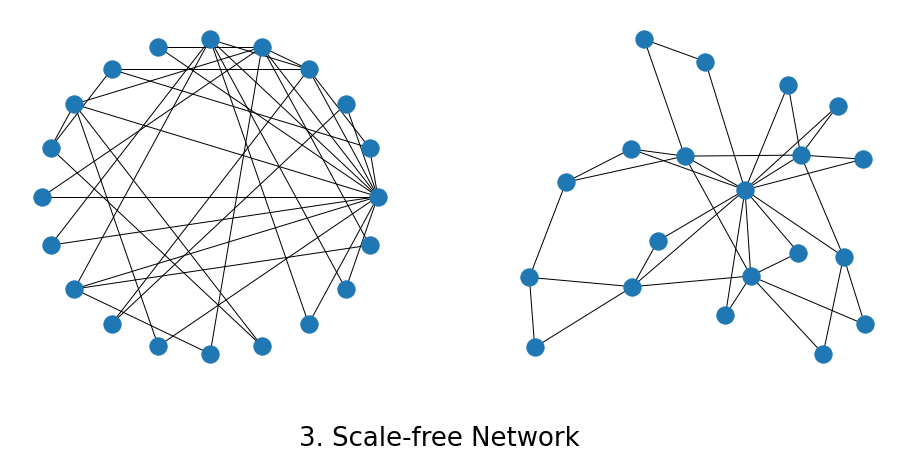

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

nx.draw(B, ax=ax[1], edge_color='black')
nx.draw_circular(B, ax=ax[0], edge_color='black')

txt="3. Scale-free Network"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=26)
plt.savefig('../report/media/networks/scalefree.png')